In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import pickle as pkl

import time
import pyrealsense2 as rs
import cv2
import torch



sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
 
from force_control import z_force_control
from probe_control import find_surface, find_object,    \
                        centralize_object

%load_ext autoreload
%autoreload 2

# Connect to robot

In [2]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


# Connect to ultrasound image stream

In [3]:
ultrasound_vid = cv2.VideoCapture('/dev/video7')

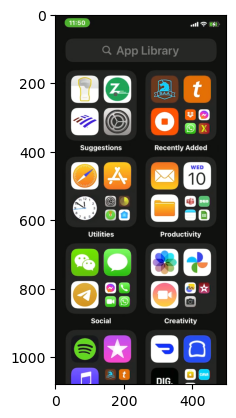

In [4]:
ret, frame = ultrasound_vid.read()		
plt.imshow(frame)

# Connect to RGB-D Camera

In [5]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [6]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
    
# body_color_rgb = (227,124,100)
body_hsv_rad = (50,50,100)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [7]:
move_default_pose(rtde_c)

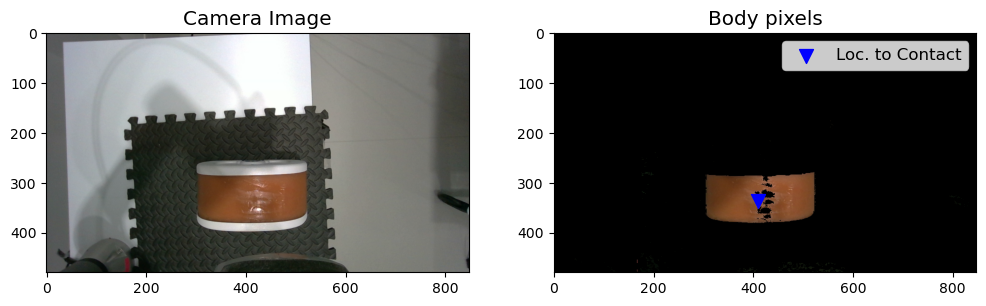

In [7]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plt.rcParams.update({'font.size':12})
sc.showScene([ax1,ax2])


In [33]:
# Start the control pipeline
move_default_pose(rtde_c)

RTDEReceiveInterface Exception: End of file
RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: End of file
RTDEControlInterface: Robot is disconnected, reconnecting...
RTDEControlInterface Exception: Timeout connecting to UR dashboard server.


Reconnecting...


# Find body surface and make contact

In [14]:
# Start the control pipeline
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

Arrived at above target location. Start descending.
Contact made.


# Apply a desirable amount of force

In [15]:
target_force = 20
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

Current force is:0.5973723590632218:  Time elapsed=00:00

Current force is:19.64771048751237:  Time elapsed=00:12 

Target force reached.


True

In [16]:
p0 = rtde_r.getActualTCPPose()

# Move in x and y directions and record US images

In [32]:
rtde_c.moveL(p0,0.05,0.1)

True

In [31]:
n_wp = 4
speed = 0.01
acc = 0.1
x_waypoints = [[p0[0]+i/1000]+p0[1:] for i in range(n_wp)]
y_waypoints = [[p0[0]]+[p0[1]-2*i/100]+p0[2:] for i in range(n_wp)]

x_obs = []
y_obs = []

for wp in x_waypoints:
    rtde_c.moveL(wp,speed,acc)
    time.sleep(0.5)
    _,f = ultrasound_vid.read()
    
    x_obs.append((f,rtde_r.getActualTCPPose()))


for wp in y_waypoints:
    rtde_c.moveL(wp,speed,acc)
    time.sleep(0.5)
    _,f = ultrasound_vid.read()
    
    y_obs.append((f,rtde_r.getActualTCPPose()))

In [29]:
# Save data
with open('xy_sensitivity.pkl','wb') as fp:
    pkl.dump({'x_obs':x_obs,'y_obs':y_obs},fp)